# Etudes de phénomènes aérospatiaux non identifiés (PAN) de 1910 à 2014

# Communiquez vos résultats - partie 2
# Analyses des phénomènes dans le monde entier

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importation-et-lecture-du-fichier-principal-(ufo_clean)" data-toc-modified-id="Importation-et-lecture-du-fichier-principal-(ufo_clean)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importation et lecture du fichier principal (ufo_clean)</a></span><ul class="toc-item"><li><span><a href="#Etude-des-UFO_shape" data-toc-modified-id="Etude-des-UFO_shape-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Etude des UFO_shape</a></span></li><li><span><a href="#Etude-temporelle-des-phénomènes" data-toc-modified-id="Etude-temporelle-des-phénomènes-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Etude temporelle des phénomènes</a></span></li><li><span><a href="#Etude-géographique-des-phénomènes" data-toc-modified-id="Etude-géographique-des-phénomènes-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Etude géographique des phénomènes</a></span></li></ul></li></ul></div>

## Importation et lecture du fichier principal (ufo_clean)

Importation des librairies nécessaires à l'exécution du code

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly
import plotly.express as px
import json
from datetime import datetime
import re
import datetime

# Librairies statistiques
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.stats import ks_2samp

# Librairies de visualisation
from folium import Choropleth
from folium.plugins import HeatMap
from urllib.request import urlopen

from PIL import Image
from wordcloud import WordCloud

import plotly.figure_factory as ff
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode, download_plotlyjs
# jupyter set up
init_notebook_mode(connected=True)

In [2]:
#  version de pandas
print(f'version pandas : {pd.__version__}')
#  version de numpy
print(f'version numpy : {np.__version__}')
#  version de folium
print(f'version folium : {folium.__version__}')
# version de plotly
print(f'version plotly : {plotly.__version__}')
#  version de plotly express
# print(f'version plotly express : {px.__version__}')

version pandas : 1.1.3
version numpy : 1.19.2
version folium : 0.12.1
version plotly : 4.14.3


In [3]:
ENCODAGE = 'UTF-8'

In [4]:
TEMPLATE = 'plotly_dark'

In [5]:
COLORS = {'Canada':'#fdca26',
          'United Kingdom':'#35b779',
          'USA':'#0d0887'}

In [6]:
COLOR_EVOLUTION = 'Plasma_r'
COLOR_UFO_SHAPE = px.colors.sequential.Mint
COLOR_UFO_DURATION = px.colors.sequential.Blues

In [7]:
sns.set(style="darkgrid")

Importation du dataset comprenant **tous** les pays

In [8]:
df_ufo_tot = pd.read_csv("ufo_clean.csv",
                         encoding=ENCODAGE,
                         parse_dates=['dates_time'])

In [9]:
df_ufo_tot.head(2)

,dates_time,city,state/province,country,UFO_shape,length_of_encounter_seconds,latitude,longitude
0,1949-10-10 20:30:00,San Marcos,TX,USA,cylinder,2700.0,29.883056,-97.941111
1,1949-10-10 21:00:00,Lackland Afb,TX,USA,light,7200.0,29.384210,-98.581082


Dimension du fichier

In [10]:
df_ufo_tot.shape

(75325, 8)

In [11]:
df_ufo_tot.dropna(axis=0, inplace=True)

Aucune valeur null

In [12]:
df_ufo_tot.isnull().sum()

dates_time                     0
city                           0
state/province                 0
country                        0
UFO_shape                      0
length_of_encounter_seconds    0
latitude                       0
longitude                      0
dtype: int64

Pour les analyses temporelles, nous allons créer une colonne `year` et une colonne `month`

Les 4 pays qui ont le plus de phénomènes recensés sont :

In [13]:
df_ufo_tot.country.value_counts().head(4)

USA               68486
Canada             3522
United Kingdom     2140
Australia           278
Name: country, dtype: int64

Quelle est la part représentative des différents pays dans le fichier ?

Création d'une colonne `principal_country` qui indiquera "other_countries" pour les pays autres que les USA, le Canada et l'UK

In [14]:
# Initialisation de la colonne à "other_countries"
df_ufo_tot['principal_country'] = 'other_countries'

In [15]:
# Remplissage de la colonne en fonction de la valeur dans "country"
df_ufo_tot.loc[df_ufo_tot['country'] == 'USA',
               'principal_country'] = 'USA'
df_ufo_tot.loc[df_ufo_tot['country'] == 'United Kingdom',
               'principal_country'] = 'United Kingdom'
df_ufo_tot.loc[df_ufo_tot['country'] == 'Canada',
               'principal_country'] = 'Canada'

In [16]:
df_ufo_tot.head(2)

,dates_time,city,state/province,country,UFO_shape,length_of_encounter_seconds,latitude,longitude,principal_country
0,1949-10-10 20:30:00,San Marcos,TX,USA,cylinder,2700.0,29.883056,-97.941111,USA
1,1949-10-10 21:00:00,Lackland Afb,TX,USA,light,7200.0,29.384210,-98.581082,USA


Les USA sont largement majoritairement représentés suivi du Canada puis de l'UK.  
La part représentée par l'ensemble des autres pays `other_countries` est la plus faible.  
A l'évidence, le dataset rassemble essentiellement des données relatives aux USA.

In [17]:
ufo_count = df_ufo_tot.principal_country.value_counts()
ufo_count

USA                68486
Canada              3522
United Kingdom      2140
other_countries     1175
Name: principal_country, dtype: int64

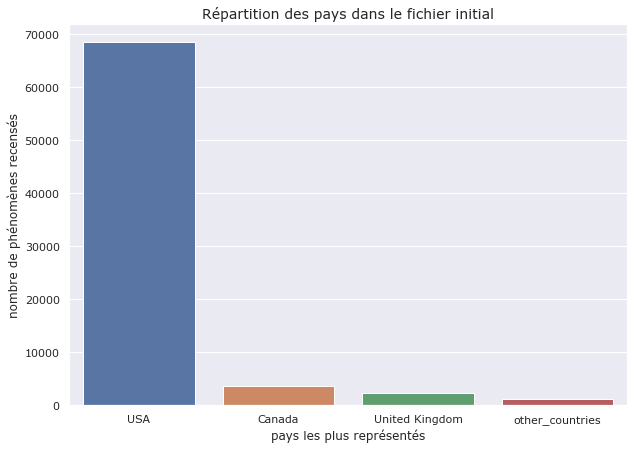

In [18]:
order_country = df_ufo_tot.principal_country\
    .value_counts(ascending=False)\
    .index
plt.figure(figsize=(10, 7))
sns.set(font="Verdana")
sns.countplot(x='principal_country',
              data=df_ufo_tot,
              order=order_country)
plt.title("Répartition des pays dans le fichier initial", size=14)
plt.xlabel("pays les plus représentés", size=12)
plt.ylabel("nombre de phénomènes recensés", size=12)
plt.show();

Plotly

In [19]:
df_count_country = df_ufo_tot.groupby('principal_country').agg(
    count_country=('principal_country', 'count')
).reset_index()

In [20]:
# Couleurs des différents pays
colors = ['#0d0887', '#bd3786', '#fb9f3a', '#f0f921']
layout = go.Layout(title="Part mondiale des phénomènes<br>"
                   "<sup>(de 1910 à 2014)</sup>",
                   font=dict(family='Arial',
                             size=14,
                             ),
                   template=TEMPLATE)

# Création de la figure
fig = go.Figure(data=[go.Pie(labels=['USA', 'Canada',
                                     'United Kingdom', 'other countries'],
                             values=[68486, 3522,
                                     2140, 1175])],
                layout=layout)

# Labels
fig.update_traces(hoverinfo='label+percent',
                  textfont_size=12,
                  textinfo='label+percent',
                  pull=[0, 0.3, 0.2, 0.1],
                  marker=dict(colors=colors,
                              line=dict(color='#FFFFFF',
                                        width=0))
                  )


# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.005,
                        xanchor='center', yanchor='top',
                        text="Source: fichier nettoyé ufo_clean.csv<br>"
                        "  (fichier original: https://www.kaggle.com/camnugent"
                        "/ufo-sightings-around-the-world)",


                        font=dict(family='Arial',
                                  size=14,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)
# fig.show()

En résumé : les pays les plus représentés dans le dataset `df_ufo` sont : USA, Canada et le Royaume-Uni

### Etude des UFO_shape

Liste des phénomènes recencés dans le fichier

In [21]:
df_ufo_tot.UFO_shape.value_counts()

light        15956
triangle      7625
circle        7270
fireball      5996
unknown       5387
other         5376
sphere        5180
disk          4946
oval          3559
formation     2367
cigar         1976
changing      1878
flash         1278
rectangle     1258
cylinder      1239
diamond       1129
chevron        926
teardrop       723
egg            721
cone           294
cross          223
delta            7
crescent         2
round            2
changed          1
hexagon          1
dome             1
pyramid          1
flare            1
Name: UFO_shape, dtype: int64

Nombre de formes des phénomènes différentes

In [22]:
# Nombre de phénomènes différents
df_ufo_tot.UFO_shape.nunique()

29

Pour la suite de l'étude, les phénomènes observés seront ultérieurement regroupés suivant des caractéristiques de forme communes.

Fréquence des phénomènes

Plotly

In [23]:
df_count_ufo = df_ufo_tot.groupby('UFO_shape').agg(
    count_ufo=('UFO_shape', 'count')
).sort_values(by='count_ufo').reset_index()

In [24]:
# Création de la figure
fig = px.bar(df_count_ufo,
             y='UFO_shape',
             x='count_ufo',
             text='count_ufo',
             labels={'count_ufo': 'Nombre de phénomènes',
                     'UFO_shape': 'Forme du phénomène'},
             color='count_ufo',
             color_continuous_scale=COLOR_UFO_SHAPE,
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')
fig.update_layout(title='Fréquence des différentes formes de phénomènes dans le monde',
                  showlegend=True)

# Axes
fig.update_xaxes(showgrid=True, ticks="outside")

# Annotation
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.14,
                              xanchor='center', yanchor='top',
                              text='Note: fréquence couvrant la période de 1910 à 2014',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(annotations=annotations)


fig.show()

Les PAN lumineux sont les plus nombreux

Nombre de phénomènes en fonction de leur durée

In [25]:
df_count_ufo_bubble = df_ufo_tot.groupby(['UFO_shape']).agg(
    count_ufo=('UFO_shape', 'count'),
    mean_length_of_encounter_seconds=('length_of_encounter_seconds', 'mean')
).sort_values(by='count_ufo').reset_index()             
df_count_ufo_bubble.head(2)

,UFO_shape,count_ufo,mean_length_of_encounter_seconds
0,changed,1,3600.0
1,hexagon,1,240.0


In [26]:
# Graph
fig = px.scatter(df_count_ufo_bubble,
                 x="mean_length_of_encounter_seconds",
                 y="count_ufo",
                 size="count_ufo",
                 color="UFO_shape",
                 log_x=True,
                 size_max=60,
                 template=TEMPLATE,
                 labels={'count_ufo': 'Nombre de phénomènes',
                         'mean_length_of_encounter_seconds': 'durée moyenne (seconde)'},
                 title="Nombre de phénomènes en fonction de leur durée")

# Text
fig.update_layout(title="Nombre de phénomènes en fonction de leur durée moyenne<br>"
                  "<sup>(dans le monde)</sup>",
                  showlegend=True,
                  legend_title_text='Forme du phénomène',
                  xaxis=dict(
                        showline=True,
                        showgrid=True,
                        showticklabels=True,
                        linecolor='rgb(204, 204, 204)',
                        linewidth=1,
                        ticks='outside',
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='rgb(82, 82, 82)'
                        ),
                  ),
                  yaxis=dict(
                      showgrid=True,
                      zeroline=False,
                      showline=True,
                      showticklabels=True,
                      linecolor='rgb(204, 204, 204)',
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)'
                      ),
                  )                 
                  )
# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.18,
                        xanchor='center', yanchor='top',
                        text='Note: période de 1910 à 2014',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))
# Graph annotation
annotations.append(dict(xref='x', yref='y',
                        x=5, y=294,
                        text="forme conique",
                        showarrow=True,
                        font=dict(
                            family="Arial, monospace",
                            size=12,
                            color="#ffffff"
                        ),
                        align="center",
                        arrowhead=2,
                        arrowsize=1,
                        arrowwidth=2,
                        arrowcolor="#636363",
                        ax=62,
                        ay=-40,
                        bordercolor="#c7c7c7",                       
                        bgcolor="#FECB52",
                        opacity=0.8
                        ))

# Graph annotation
annotations.append(dict(xref='x', yref='y',
                        x=4.51, y=15956,
                        text="forme lumineuse",
                        showarrow=True,
                        font=dict(
                            family="Arial, monospace",
                            size=12,                            
                        ),
                        align="center",
                        arrowhead=2,
                        arrowsize=1,
                        arrowwidth=2,
                        arrowcolor="#636363",
                        ax=62,
                        ay=-40,                       
                        bgcolor="#FF97FF",
                        opacity=0.8
                        ))

fig.update_layout(annotations=annotations)
fig.show()

Les phénomènes lumineux sont largement les plus observés. Les formes coniques sont les plus persistantes.

Les phénomènes en MOTS

In [27]:
import random


# Couleur du nuage de mot
def grey_color_func(word, font_size, position, 
                    orientation, random_state=None,
                    **kwargs):      
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

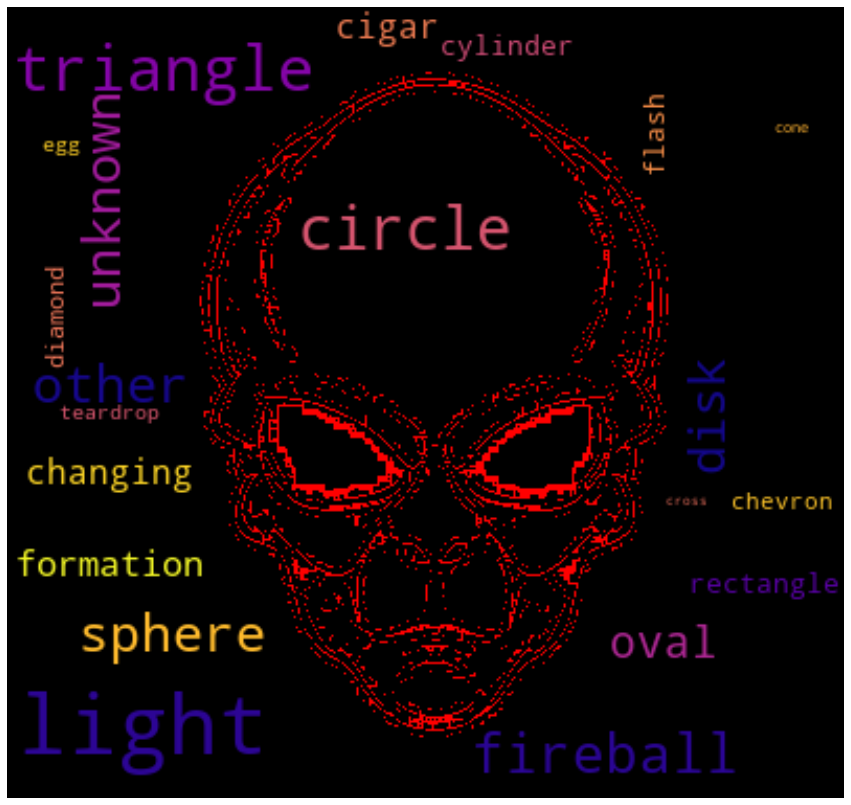

In [28]:
from PIL import Image
from wordcloud import WordCloud
mask = np.array(Image.open("alien10.png"))
mask[mask == 1] = 255

wc = WordCloud(width=3000,
               height=2000,
               mask=mask,
               background_color='black',
               colormap='plasma', 
               contour_color='red', 
               contour_width=1)

text = df_ufo_tot.UFO_shape.value_counts().sort_values(ascending=False)

wc.generate_from_frequencies(text.to_dict(), max_font_size=40)
# plt.figure(figsize=(15,8))
# plt.axis('off')
# plt.imshow(wc.recolor(color_func=couleur), interpolation='bilinear')

plt.figure(figsize=[15, 15])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
# plt.show()
plt.savefig("alien_mot19.jpg")

Il est possible de rassembler les différentes formes afin de réduire leur nombre 

Création d'une colonne `cat_UFO_shape` qui regroupe les différentes formes des phénomènes

In [29]:
var_light = ['light', 'flash',
             'flare', 'fireball']
var_ovoid = ['sphere', 'teardrop',
             'egg', 'round', 'circle',
             'disk', 'oval', 'crescent', 'round']
var_angle = ['chevron', 'delta',
             'rectangle', 'triangle',
             'diamond', 'cone', 
             'pyramid', 'dome', 
             'hexagon', 'cross', 'cone']
var_other = ['unknown', 'other']
var_cylinder = ['cigar', 'cylinder']
var_formation = ['formation']
var_changing = ['changing', 'changed']


for elt in var_light:
    df_ufo_tot.loc[df_ufo_tot['UFO_shape'] == elt, 
                   'cat_UFO_shape'] = 'light_shape'

for elt in var_ovoid:
    df_ufo_tot.loc[df_ufo_tot['UFO_shape'] == elt, 
                   'cat_UFO_shape'] = 'ovoid_shape'

for elt in var_angle:
    df_ufo_tot.loc[df_ufo_tot['UFO_shape'] == elt,
                   'cat_UFO_shape'] = 'angular_shape'

for elt in var_other:
    df_ufo_tot.loc[df_ufo_tot['UFO_shape'] == elt,
                   'cat_UFO_shape'] = 'other_shape'

for elt in var_cylinder:
    df_ufo_tot.loc[df_ufo_tot['UFO_shape'] == elt,
                   'cat_UFO_shape'] = 'cylinder_shape'

for elt in var_formation:
    df_ufo_tot.loc[df_ufo_tot['UFO_shape'] == elt,
                   'cat_UFO_shape'] = 'formation_shape'

for elt in var_changing:
    df_ufo_tot.loc[df_ufo_tot['UFO_shape'] == elt,
                   'cat_UFO_shape'] = 'changing_shape'

Décompte des catégories de formes

In [30]:
# Décompte des nouveaux groupes de formes
df_ufo_tot.cat_UFO_shape.value_counts()

light_shape        23231
ovoid_shape        22403
angular_shape      11465
other_shape        10763
cylinder_shape      3215
formation_shape     2367
changing_shape      1879
Name: cat_UFO_shape, dtype: int64

Fréquence des phénomènes dans le monde par leur catégorie de forme 

In [31]:
df_ufo_tot_freq = df_ufo_tot.groupby("cat_UFO_shape").agg(
    mean_length_of_encounter_seconds=(
        "length_of_encounter_seconds", "mean"),
    count_cat_UFO_shape=(
        "cat_UFO_shape", "count")
).reset_index(
).sort_values(by='mean_length_of_encounter_seconds')

In [32]:
df_ufo_tot_freq_cat = df_ufo_tot_freq.sort_values(by="count_cat_UFO_shape")

plotly

In [33]:
# Graph
fig = px.bar(df_ufo_tot_freq_cat,
             y='cat_UFO_shape',
             x='count_cat_UFO_shape',
             text='count_cat_UFO_shape',
             labels={'count_cat_UFO_shape': 'Nombre de phénomènes',
                     'cat_UFO_shape': 'Forme du phénomène'},
             color='count_cat_UFO_shape',
             color_continuous_scale=COLOR_UFO_SHAPE,
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')

fig.update_layout(title='Fréquence des phénomènes mondiaux<br>'
                  "<sup>période de 1910 à 2014</sup>",
                  showlegend=True)

fig.update_xaxes(showgrid=True, ticks="outside")

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: dataset df_ufo_tot.csv'+
                        '   Les phénomènes sont rassemblés en catégorie de forme',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

Au niveau mondial, les phénomènes lumineux et ovoïdes sont majoritaires  
Les phénomènes changeants ou en formation sont minoritaires

Durée moyenne des phénomènes dans le monde en fonction de leur forme

In [34]:
df_ufo_tot_freq_dur = df_ufo_tot_freq.sort_values(
    by="mean_length_of_encounter_seconds")

In [35]:
df_ufo_tot_freq_dur.head(2)

,cat_UFO_shape,mean_length_of_encounter_seconds,count_cat_UFO_shape
3,formation_shape,1261.519341,2367
1,changing_shape,2095.273177,1879


In [36]:
# Graph
fig = px.bar(df_ufo_tot_freq_dur,
             y='cat_UFO_shape',
             x='mean_length_of_encounter_seconds',
             text='mean_length_of_encounter_seconds',
             labels={'mean_length_of_encounter_seconds': 'Durée moyenne du phénomène (seconde)',
                     'cat_UFO_shape': 'Catégorie de forme'},
             color='mean_length_of_encounter_seconds',
             color_continuous_scale=COLOR_UFO_DURATION,
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')

fig.update_layout(
    title='Durée moyenne des phénomènes mondiaux<br>'
    "<sup>(de 1910 à 2014)</sup>",
    showlegend=True)

# Axes
fig.update_xaxes(showgrid=True,
                 ticks="outside")

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: dataset df_ufo_tot.csv' +
                        '   Toutes les durées sont prises en compte (même les plus longues)',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))


fig.update_layout(annotations=annotations)

fig.show()

La majorité des phénomènes de longues durées ne sont pas répertoriés  
Les phénomènes lumineux sont les plus longs  
Les phénomènes en formation ou changeants sont les plus courts

Nombre des phénomènes mondiaux (par catégorie de forme) en fonction de leur durée moyenne 

In [37]:
# Graph
fig = px.scatter(df_ufo_tot_freq_cat,
                 x="mean_length_of_encounter_seconds",
                 y="count_cat_UFO_shape",
                 size="count_cat_UFO_shape",
                 color="cat_UFO_shape",
                 log_x=True,
                 size_max=60,
                 template=TEMPLATE,
                 #                  text='count_cat_UFO_shape',
                 labels={'count_cat_UFO_shape': 'Nombre de phénomènes',
                         'mean_length_of_encounter_seconds': 'durée moyenne (seconde)',
                         'cat_UFO_shape': 'Catégorie de forme'},
                 title="Nombre de phénomènes en fonction de leur durée")

# Text
fig.update_layout(title="Nombre de phénomènes mondiaux<br>"
                  "en fonction de leur durée moyenne</br>",
                  showlegend=True,
                  xaxis=dict(
                        showline=True,
                        showgrid=True,
                        showticklabels=True,
                        linecolor='rgb(204, 204, 204)',
                        linewidth=2,
                        ticks='outside',
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='rgb(82, 82, 82)'
                        ),
                  ),
                  yaxis=dict(
                      showgrid=True,
                      zeroline=False,
                      linecolor='rgb(204, 204, 204)',
                      showline=True,
                      showticklabels=True,
                      linewidth=2,
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)'
                      ),
                  )
                  #                   plot_bgcolor='white'
                  )
# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.18,
                        xanchor='center', yanchor='top',
                        text='Source: dataset df_ufo_tot.csv   ' +
                        '    Sans suppression des durées les plus longues',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)
fig.show()

Les phénomènes lumineux et ovoïdes sont majoritaires et de longue durée. Les formes indéterminées sont des phénomènes les plus persistants.

### Etude temporelle des phénomènes

Création d'une colonne `year`pour avoir les années

In [38]:
# Création de la colonne "year"
df_ufo_tot["year"] = df_ufo_tot.dates_time.dt.year

Création d'une colonne `month` pour avoir les mois

In [39]:
# Création de la colonne "month"
df_ufo_tot["month"] = df_ufo_tot.dates_time.dt.month

Création d'une colonne `day` pour avoir les jour de la semaine

In [40]:
# Création de la colonne "day"
df_ufo_tot["day"] = df_ufo_tot.dates_time.dt.day

Création d'une colonne `hour` pour avoir les heures

In [41]:
# Création de la colonne "hour"
df_ufo_tot["hour"] = df_ufo_tot.dates_time.dt.hour

Dimension du fichier 

In [42]:
df_ufo_tot.shape

(75323, 14)

Visualisation de la distribution des phénomènes de 1910 à 2014

In [43]:
df_ufo_tot_gp = df_ufo_tot.groupby(["year"]).agg(
                count_ufo_shape=("UFO_shape", "count"))

In [44]:
df_ufo_tot_gp.reset_index(inplace=True)

plotly

In [45]:
# Graph
fig = px.bar(df_ufo_tot_gp,
             y='count_ufo_shape',
             x='year',
             text='count_ufo_shape',
             labels={'count_ufo_shape': 'Nombre de phénomènes',
                     'year': 'année'},
             color="count_ufo_shape",
             color_continuous_scale=COLOR_EVOLUTION,
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')

fig.update_layout(title='Evolution des phénomènes mondiaux<br>'
                  "<sup>de 1910 à 2014</sup>",
                  showlegend=True,
                  xaxis=dict(
                        showline=True,
                        showgrid=True,
                        showticklabels=True,
                        linecolor='rgb(204, 204, 204)',
                        linewidth=2,
                        ticks='outside',
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='rgb(82, 82, 82)'
                        ),
                  ),
                  yaxis=dict(
                      showgrid=True,
                      zeroline=False,
                      showline=False,
                      showticklabels=True,
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)'
                      ),
                  )
                  #                   plot_bgcolor='white'
                  )
# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: dataset "df_ufo_tot.csv" ' +
                        ' Tous les pays du fichier sont représentés',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)
fig.show()

Remarque:  
- maximun de phénomènes pour l'année 2012 
- à partir de 1997, accroissement des observations

Evolution mondiale des phénomènes de 1910 à 2014

In [46]:
# Graph
fig = px.line(df_ufo_tot_gp,
              x='year',
              y='count_ufo_shape',
              labels={'count_ufo_shape': 'Nombre de phénomènes',
                      'year': 'année'},
              template=TEMPLATE)

# Text
fig.update_layout(title='Evolution des phénomènes<br>'
                  "<sup>de 1910 à 2014</sup>",
                  showlegend=True)

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: dataset "df_ufo_tot.csv"   ' +
                        '   Tous les pays du fichier sont représentés',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))


# Graph annotation
annotations.append(dict(xref='x', yref='y', x=2012, y=7081,
                        text="Maximum de phénomènes<br>"
                        "en 2012<br>avec 7081 observations",
                        showarrow=True,
                        font=dict(
                            family="Arial, monospace",
                            size=12                           
                        ),
                        align="center",
                        arrowhead=2,
                        arrowsize=1,
                        arrowwidth=2,
                        arrowcolor="#636363",
                        ax=62,
                        ay=-40,                        
                        bgcolor="#3366CC",
                        opacity=0.8
                        ))
annotations.append(dict(xref='x', yref='y', x=1947, y=33,
                        text="1er pic d'observations de phénomènes<br>"
                        "en 1947<br>avec 33 observations",
                        showarrow=True,
                        font=dict(
                            family="Arial, monospace",
                            size=12,                            
                        ),
                        align="center",
                        arrowhead=2,
                        arrowsize=1,
                        arrowwidth=2,
                        arrowcolor="#636363",
                        ax=62,
                        ay=-40,                       
                        bgcolor="#3366CC",
                        opacity=0.8
                        ))

fig.update_layout(annotations=annotations)
fig.show()

Visualisation de la distribution mensuelles des phénomènes au niveau mondial

In [47]:
df_ufo_tot_month_gp = df_ufo_tot.groupby(["month"]).agg(
    count_ufo_shape=("UFO_shape", "count"))\
    .reset_index()

Dimension du dataset

In [48]:
df_ufo_tot_month_gp.shape

(12, 2)

Plotly

In [49]:
# Graph
fig = px.bar(df_ufo_tot_month_gp,
             y='count_ufo_shape',
             x='month',
             text='count_ufo_shape',
             labels={'count_ufo_shape': 'Nombre de phénomènes (par mois)',
                     'month': 'Mois'},
             color="count_ufo_shape",
             color_continuous_scale=COLOR_EVOLUTION,
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')

fig.update_layout(title='Evolution des phénomènes mondiaux<br>'
                  'par mois<br>',
                  showlegend=True,
                  xaxis=dict(
                        showline=True,
                        showgrid=False,
                        showticklabels=True,
                        linecolor='rgb(204, 204, 204)',
                        linewidth=2,
                        ticks='outside',
                        tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                        ticktext=['janvier', 'février', 'mars', 'avril',
                                  'mai', 'juin', 'juillet', 'août',
                                  'septembre', 'octobre', 'novembre', 'décembre'],
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='rgb(82, 82, 82)'
                        ),                      
                  ),
                  yaxis=dict(
                      showgrid=False,
                      zeroline=False,
                      showline=False,
                      showticklabels=True,
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)'
                      ),
                  )
                  #                   plot_bgcolor='white'
                  )
# Axes
fig.update_xaxes(tickangle=45)

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.2, y=-0.205,
                        xanchor='right', yanchor='top',
                        text='Source: dataset "df_ufo_tot.csv" ',                        
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

# Graph annotation
annotations.append(dict(xref='x', yref='y',
                        x=7, y=9125,
                        text="max=9125",
                        showarrow=True,
                        font=dict(
                            family="Arial, monospace",
                            size=14,
                            color="#ffffff"
                        ),
                        align="center",
                        arrowhead=2,
                        arrowsize=1,
                        arrowwidth=2,
                        arrowcolor="#636363",
                        ax=60,
                        ay=-40,
                        bordercolor="#c7c7c7",
                        borderwidth=0,
                        borderpad=4,
                        bgcolor="#3366CC",
                        opacity=0.8
                        ))

fig.update_layout(annotations=annotations)
fig.show()

Les phénomènes sont plus remarqués durant les mois estivaux

Visualisation de la distribution des phénomènes au niveau mondial par heure

In [50]:
df_ufo_tot_hour_gp = df_ufo_tot.groupby(["hour"]).agg(
    count_ufo_shape=("UFO_shape", "count"))\
    .reset_index()

Dimension du fichier

In [51]:
df_ufo_tot_hour_gp.shape

(24, 2)

Plotly

In [52]:
# Graph
fig = px.bar(df_ufo_tot_hour_gp,
             y='count_ufo_shape',
             x='hour',
             text='count_ufo_shape',
             labels={'count_ufo_shape': 'Nombre de phénomènes (par heure)',
                     'hour': 'Heure'},
             color="count_ufo_shape",
             color_continuous_scale=COLOR_EVOLUTION,
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')

fig.update_layout(title='Evolution des phénomènes mondiaux<br>'
                  'par heure<br>',
                  showlegend=True,
                  xaxis=dict(
                        showline=True,
                        showgrid=False,
                        showticklabels=True,
                        linecolor='rgb(204, 204, 204)',
                        linewidth=2,
                        ticks='outside',
                        tickvals=df_ufo_tot_hour_gp['hour'].tolist(),
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='rgb(82, 82, 82)'
                        ),
                  ),
                  yaxis=dict(
                      showgrid=False,
                      zeroline=True,
                      showline=False,
                      showticklabels=True,
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)'
                      ),
                  )
                  #                   plot_bgcolor='white'
                  )

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.13,
                        xanchor='center', yanchor='top',
                        text='Source: dataset "df_ufo_tot.csv" ',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)
fig.show()

Les phénomènes sont plus fréquemment observés vers 21h - 22h

La forme des phénomènes dépend-elle de l'heure ?

In [53]:
df_ufo_tot.head(2)

,dates_time,city,state/province,country,UFO_shape,length_of_encounter_seconds,latitude,longitude,principal_country,cat_UFO_shape,year,month,day,hour
0,1949-10-10 20:30:00,San Marcos,TX,USA,cylinder,2700.0,29.883056,-97.941111,USA,cylinder_shape,1949,10,10,20
1,1949-10-10 21:00:00,Lackland Afb,TX,USA,light,7200.0,29.384210,-98.581082,USA,light_shape,1949,10,10,21


In [54]:
df_ufo_tot_hour_shape_gp = df_ufo_tot.groupby(["hour"]).agg(
    ufo_shape=("cat_UFO_shape", "value_counts"))\
    .reset_index()

Dimension du fichier

In [55]:
df_ufo_tot_hour_shape_gp.shape

(168, 3)

Décompte des formes des phénomènes en fonction de l'heure

In [56]:
df_ufo_tot_hour_shape_gp

,hour,cat_UFO_shape,ufo_shape
0,0,ovoid_shape,1318
1,0,light_shape,1311
2,0,angular_shape,708
3,0,other_shape,664
4,0,formation_shape,142
...,...,...,...
163,23,angular_shape,1252
164,23,other_shape,1019
165,23,formation_shape,231
166,23,cylinder_shape,194


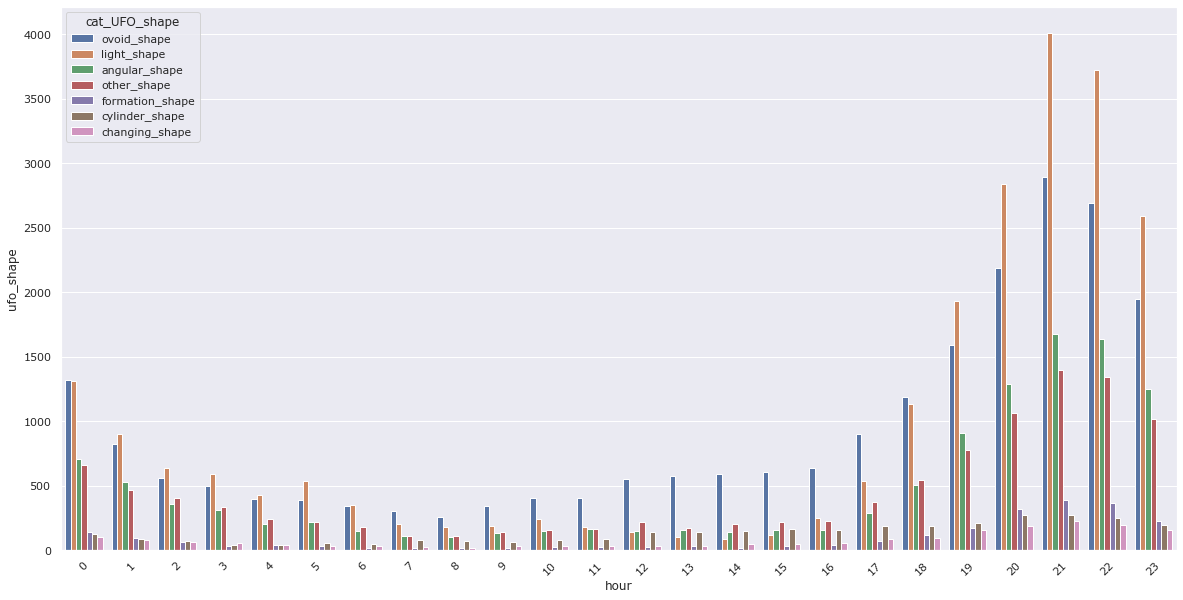

In [57]:
plt.figure(figsize=(20, 10))
sns.barplot(x='hour',
            y='ufo_shape',
            data=df_ufo_tot_hour_shape_gp,
            hue="cat_UFO_shape")
plt.xticks(rotation=45)
plt.show()

Les phénomènes sont les moins nombreux de 6h à 16h, soit durant la journée  
En revanche, à partir de 17h et jusqu'à 21h, les phénomènes sont les plus nombreux  
On observe une décroissance du nombre de phénomène à partir de 00h, pour atteidre un minimun à 8h.  
Les phénomènes lumineux restent majoritaire quelque soit l'heure

### Etude géographique des phénomènes

Il peut être intéressant de croiser les données géographiques avec des installations publiques ou militaires (aéroport, bases...)

Importation d'un fichier répertoriant la localisation des **aéroports mondiaux**  
Source: https://data.opendatasoft.com/explore/dataset/osm-world-airports@babel/export/?

In [58]:
df_airport = pd.read_csv("osm-world-airports.csv", sep=';',
                         encoding=ENCODAGE, engine='python')

In [59]:
df_airport = df_airport[["Country", "Country code", "Name", "Geo Point"]]

In [60]:
df_airport.head(2)

,Country,Country code,Name,Geo Point
0,United States of America,US,Las Cruces International Airport,"32.286877,-106.9220857"
1,United States of America,US,Sawyer International Airport,"46.349652,-87.3871745"


Type des variables

In [61]:
df_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       615 non-null    object
 1   Country code  613 non-null    object
 2   Name          662 non-null    object
 3   Geo Point     662 non-null    object
dtypes: object(4)
memory usage: 20.8+ KB


Création des variables `latitude` et `longitude` à partir de `Geo Point`  

In [62]:
df_airport['latitude'] = df_airport['Geo Point'].str.split(',', 1).str[0]
df_airport['latitude'] = df_airport['latitude'].astype(float)

df_airport['longitude'] = df_airport['Geo Point'].str.split(',', 1).str[1]
df_airport['longitude'] = df_airport['longitude'].astype(float)

Type des variables 

In [63]:
df_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       615 non-null    object 
 1   Country code  613 non-null    object 
 2   Name          662 non-null    object 
 3   Geo Point     662 non-null    object 
 4   latitude      662 non-null    float64
 5   longitude     662 non-null    float64
dtypes: float64(2), object(4)
memory usage: 31.2+ KB


Importation du fichier répertoriant les localisations des **bases militaires**  
Source: https://catalog.data.gov/dataset/military-installations-ranges-and-training-areas

In [64]:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [65]:
usecols = ["Geo Point", "COMPONENT", "Site Name", "COUNTRY"]
df_military_us = pd.read_csv("military-bases.csv",
                             sep=';',
                             encoding=ENCODAGE,
                             usecols=usecols)

In [66]:
df_military_us.head(2)

,Geo Point,COMPONENT,Site Name,COUNTRY
0,"19.7144170574,-155.626600781",Army Active,Pohakuloa Training Area,United States
1,"34.0182119696,-77.9732412004",Army Active,Military Ocean Tml Sunny Point,United States


Dimension du fichier

In [67]:
df_military_us.shape

(776, 4)

Type des variables

In [68]:
df_military_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Geo Point  776 non-null    object
 1   COMPONENT  776 non-null    object
 2   Site Name  776 non-null    object
 3   COUNTRY    776 non-null    object
dtypes: object(4)
memory usage: 24.4+ KB


Typage des variables `longitude` et `latitude`

In [69]:
df_military_us['latitude'] = df_military_us['Geo Point'].str.split(',', 1).str[0]
df_military_us['latitude'] = df_military_us['latitude'].astype(float)

df_military_us['longitude'] = df_military_us['Geo Point'].str.split(',', 1).str[1]
df_military_us['longitude'] = df_military_us['longitude'].astype(float)

In [70]:
df_military_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Geo Point  776 non-null    object 
 1   COMPONENT  776 non-null    object 
 2   Site Name  776 non-null    object 
 3   COUNTRY    776 non-null    object 
 4   latitude   776 non-null    float64
 5   longitude  776 non-null    float64
dtypes: float64(2), object(4)
memory usage: 36.5+ KB


In [71]:
df_military_us.COMPONENT.unique()

array(['Army Active', 'Navy Active', 'AF Active', 'AF Reserve',
       'Army Guard', 'Army Reserve', 'AF Guard', 'MC Active',
       'MC Reserve', 'WHS'], dtype=object)

Récupération des sites de l'armée air force

In [72]:
# Récupération des sites de l'armée air force
site_af_us = ['AF Active']
df_af_military_us = df_military_us.loc[
    df_military_us['COMPONENT'].isin(site_af_us), :]

Dimension du fichier

In [73]:
df_af_military_us.shape

(137, 6)

Export du fichier des bases militaires AF des USA 

In [74]:
df_af_military_us.to_csv("df_af_military_us.csv",
                         index=False,
                         encoding=ENCODAGE)

Sites militaires UK

In [75]:
url = 'https://en.wikipedia.org/wiki/List_of_British_Army_installations'

Visualisation des phénomènes dans le monde

In [76]:
df_ufo_tot.head(2)

,dates_time,city,state/province,country,UFO_shape,length_of_encounter_seconds,latitude,longitude,principal_country,cat_UFO_shape,year,month,day,hour
0,1949-10-10 20:30:00,San Marcos,TX,USA,cylinder,2700.0,29.883056,-97.941111,USA,cylinder_shape,1949,10,10,20
1,1949-10-10 21:00:00,Lackland Afb,TX,USA,light,7200.0,29.384210,-98.581082,USA,light_shape,1949,10,10,21


Réalisation d'une carte référençant les zones d'observations dans le monde  
source : https://ichi.pro/fr/creer-une-carte-simple-avec-folium-et-python-83598229110676

Nombre `state/province` 

In [77]:
df_ufo_tot['state/province'].nunique()

205

Nombre de `country`

In [78]:
df_ufo_tot.country.nunique()

626

Regroupement par `state/province` et conservation des latitudes et longitudes correspondantes afin de créer le dataset utilisé pour la carte 

In [79]:
# Récupération des colonnes interressantes ()
df_ufo_tot_state = df_ufo_tot[["latitude", "longitude", "state/province"]]

In [80]:
df_state_tot_mean = df_ufo_tot_state.groupby('state/province')\
    .agg({'latitude': 'mean',
          'longitude': 'mean'}).reset_index()

In [81]:
df_state_tot_mean.head(2)

,state/province,latitude,longitude
0,AB,52.553976,-108.105589
1,AK,59.093782,-145.489392


Dimention du dataset `df_state_tot_mean`

In [82]:
df_state_tot_mean.shape

(205, 3)

Représentation de la répartition des phénomènes par états/province dans le monde

In [83]:
# Création de la carte par Folium   
m = folium.Map(location=[31.53, -99.11], zoom_start=3)
df_state_tot_mean.apply(lambda row: folium.Marker(
    [row["latitude"], row["longitude"]],
    icon=folium.Icon(icon="info"))
.add_to(m), axis=1)
m

Il semble que les PAN soient plus nombreux sur la côte est des USA.

Représentation du nombre de phénomènes par heatmap

In [84]:
# Création de la carte HeatMap
m_2 = folium.Map(location=[40, -97.941111], zoom_start=2)
HeatMap(data=df_state_tot_mean[['latitude',
                                'longitude']], radius=10).add_to(m_2)
m_2

Visualisation de la répartition des phénomènes dans le monde

In [85]:
# Create map 
m_1 = folium.Map(location=[40, -97.941111], zoom_start=2)
HeatMap(data=df_ufo_tot[['latitude', 'longitude']],
        radius=10,
        name='Répartition des phénomènes dans le monde').add_to(m_1)
m_1
# m_1.save('répartition_phénomènes_mondiaux.html')

En conclusion : les phénomènes se répartissent de manière hétérogène.  

Par commodité, nous n'étudierons que les 3 principaux pays (USA, England et Canada). En effet, ils sont très bien représentés dans le dataset par rapport aux autres pays.